In [1]:
!pip install biopython torch

In [0]:
from IPython.display import display, HTML
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
from Bio import SeqIO
import re

def load_fasta(fname):
  parsed = []
  for seq in SeqIO.parse(fname, "fasta"):
    record = { 'seq': str(seq.seq).upper() }
    if 'trueSeq' in seq.id:
      meta = re.search('::\w+::(?P<rbps>(?:\w+(?:///)?)+)::(?P<id>\w+)', seq.id).groupdict()
      rbps = {key: 1 for key in meta['rbps'].split('///')}
      record['id'] = meta['id']
      record.update(rbps)
    parsed.append(record)
  return pd.DataFrame(parsed).fillna(0)

train = load_fasta('train.txt')
valid = load_fasta('valid.txt')
test = load_fasta('test.txt')

In [4]:
train.head()

,seq,id,ATXN2,FUS,CPSF6,HNRNPC,NUDT21,ELAVL1,LIN28B,FIP1L1,MOV10,WDR33,CPSF7,YTHDF2,CSTF2T,ZC3H7B,CAPRIN1,CPSF1,CPSF4,CPSF3,TARDBP,CSTF2
0,AGCATGTTAGAGTTCTGATGGCAGTTGTTGTTTATGAATAAGCTTC...,ENST00000545308,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AAACATATTCTATTCATTTATTTTATAACTGTTCCCTTGACCTCTT...,ENST00000606457,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CCCCACCCACCCCTTTGGAGAGGTGTCCCTCGTAACATTCTGGAGC...,ENST00000506172,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CTTGCAGTCTGAGCACGCGTAAGGCTTCTCCCCGGTGTGAGCCCGC...,ENST00000492040,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,TAATCCACAGTTTCCCAACCTCAGCCCTACTGACACTGGGGCTGGA...,ENST00000572913,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
train.tail()

,seq,id,ATXN2,FUS,CPSF6,HNRNPC,NUDT21,ELAVL1,LIN28B,FIP1L1,MOV10,WDR33,CPSF7,YTHDF2,CSTF2T,ZC3H7B,CAPRIN1,CPSF1,CPSF4,CPSF3,TARDBP,CSTF2
194978,TTTTGTTTCCTGTTAATCTTTGTATCTAGGAAAATCTAATCTGCCT...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
194979,GCCTTTTATGGGCCACTTGCATTAGTGTCCTGATAGAGGCTTAATC...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
194980,GTCTGTCTTCTGTATATACCCTGTAGATCCGAATTTGTGTAAGGAA...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
194981,GTTCAGGGTACAGCCAGGTGGGGGAGACAGATCACTATAAAAACCT...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
194982,ATGTAGCCAAAATCAGCCAGGAGCGGTGGCTCACCCCTGTAATCCC...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
from collections import Counter
train.seq.apply(Counter).sum()

Counter({'A': 10063517,
         'C': 8246631,
         'G': 8310888,
         'N': 1942403,
         'T': 10433161})

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
all_letters = "ATCG"
n_letters = len(all_letters) + 1
n_categories = len(train.columns) - 2

def seqToTensor(seq):
    tensor = torch.zeros(len(seq), 1, n_letters)
    for li, letter in enumerate(seq):
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

In [9]:
print(seqToTensor('ATCGN'))

tensor([[[1., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0.]],

        [[0., 0., 1., 0., 0.]],

        [[0., 0., 0., 1., 0.]],

        [[0., 0., 0., 0., 1.]]])


In [0]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 32
rnn = RNN(n_letters, n_hidden, n_categories)

In [0]:
criterion = nn.BCELoss()
learning_rate = 0.001

def train_seq(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [12]:
# Keep track of losses for plotting
current_loss = 0
all_losses = []
print_every = 250

for index, row in train.iterrows():
  sequence = seqToTensor(row.seq)
  categories = torch.tensor([row['ATXN2':'CSTF2']])
  output, loss = train_seq(categories, sequence)
  current_loss += loss

  if index % print_every == 0:
    print(index, current_loss / print_every)
    all_losses.append(current_loss / print_every)
    current_loss = 0
  if index > 3000:
    break

0 0.0014059231281280517
500 0.3789332799911499
750 0.37220061707496643
1000 0.3779740539193153
1250 0.359724068403244
1500 0.3644578862786293
1750 0.37713719671964646
2000 0.3684954831004143
2250 0.3643032819032669
2500 0.35363364934921265
2750 0.35783606332540513
3000 0.37170987445116044


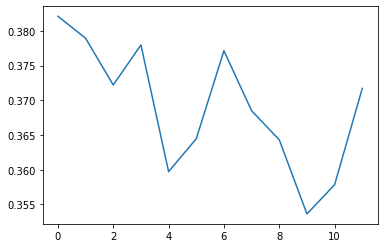

In [13]:
plt.plot(all_losses[1:])

In [0]:
test_true = []
test_pred = []
for index, row in test.iterrows():
  sequence = seqToTensor(row.seq)
  categories = torch.tensor([row['ATXN2':'CSTF2']])
  test_true.append(categories.numpy()[0])

  hidden = rnn.initHidden()
  for i in range(sequence.size()[0]):
    output, hidden = rnn(sequence[i], hidden)
  test_pred.append((output > 0.05).float().numpy()[0])

In [22]:
from sklearn.metrics import classification_report
print(classification_report(test_true, test_pred, target_names=list(test.columns[2:])))

              precision    recall  f1-score   support

       ATXN2       0.23      1.00      0.38      1802
         FUS       0.07      0.12      0.09       613
      CSTF2T       0.00      0.00      0.00       737
       MOV10       0.06      0.42      0.11       560
     CAPRIN1       0.05      0.17      0.07       391
       WDR33       0.06      0.81      0.11       455
      ELAVL1       0.22      0.55      0.32      1684
      YTHDF2       0.05      0.84      0.10       389
       CPSF6       0.08      0.12      0.09       680
      HNRNPC       0.30      0.94      0.45      2316
      ZC3H7B       0.05      0.49      0.10       395
       CPSF1       0.06      0.47      0.11       453
      LIN28B       0.13      0.66      0.22      1003
      FIP1L1       0.20      0.10      0.14      1429
      NUDT21       0.12      0.00      0.00      1303
       CPSF4       0.04      0.12      0.06       381
       CPSF7       0.05      0.50      0.09       375
       CPSF3       0.06    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
